# How to load PDFs

[Portable Document Format (PDF)](https://en.wikipedia.org/wiki/PDF), standardized as ISO 32000, is a file format developed by Adobe in 1992 to present documents, including text formatting and images, in a manner independent of application software, hardware, and operating systems.

This guide covers how to [load](/docs/concepts/document_loaders/) `PDF` documents into the LangChain [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) format that we use downstream.

Text in PDFs is typically represented via text boxes. They may also contain images. A PDF parser might do some combination of the following:

- Agglomerate text boxes into lines, paragraphs, and other structures via heuristics or ML inference;
- Run [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition) on images to detect text therein;
- Classify text as belonging to paragraphs, lists, tables, or other structures;
- Structure text into table rows and columns, or key-value pairs.

LangChain integrates with a host of PDF parsers. Some are simple and relatively low-level; others will support OCR and image-processing, or perform advanced document layout analysis. The right choice will depend on your needs. Below we enumerate the possibilities.

We will demonstrate these approaches on a [sample file](https://github.com/langchain-ai/langchain/blob/master/libs/community/tests/integration_tests/examples/layout-parser-paper.pdf):

In [5]:
file_path = (
    "../../docs/integrations/document_loaders/example_data/layout-parser-paper.pdf"
)

:::info A note on multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications -- such as question-answering over PDFs with complex layouts, diagrams, or scans -- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. We demonstrate an example of this in the [Use of multimodal models](/docs/how_to/document_loader_pdf/#use-of-multimodal-models) section below.

:::

## Simple and fast text extraction

If you are looking for a simple string representation of text that is embedded in a PDF, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects-- one per page-- containing a single string of the page's text in the Document's `page_content` attribute. It will not parse text in images or scanned PDF pages. Under the hood it uses the [pypdf](https://pypdf.readthedocs.io/en/stable/) Python library.

LangChain [document loaders](/docs/concepts/document_loaders) implement `lazy_load` and its async variant, `alazy_load`, which return iterators of `Document` objects. We will use these below.

In [ ]:
%pip install -qU pypdf

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [7]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'author': '', 'creationdate': '2021-06-22T01:27:10+00:00', 'creator': 'LaTeX with hyperref', 'keywords': '', 'moddate': '2021-06-22T01:27:10+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.14159265-2.6-1.40.21 (TeX Live 2020) kpathsea version 6.3.2', 'producer': 'pdfTeX-1.40.21', 'subject': '', 'title': '', 'trapped': '/False', 'source': '../../docs/integrations/document_loaders/example_data/layout-parser-paper.pdf', 'total_pages': 16, 'page': 0}

LayoutParser : A Uniﬁed Toolkit for Deep
Learning Based Document Image Analysis
Zejiang Shen1(  ), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain
Lee4, Jacob Carlson3, and Weining Li5
1Allen Institute for AI
shannons@allenai.org
2Brown University
ruochen zhang@brown.edu
3Harvard University
{melissadell,jacob carlson }@fas.harvard.edu
4University of Washington
bcgl@cs.washington.edu
5University of Waterloo
w422li@uwaterloo.ca
Abstract. Recent advances in document image analysis (DIA) have been
primarily driven by the applicatio

Note that the metadata of each document stores the corresponding page number.

### Vector search over PDFs

Once we have loaded PDFs into LangChain `Document` objects, we can index them (e.g., a RAG application) in the usual way. Below we use OpenAI embeddings, although any LangChain [embeddings](https://python.langchain.com/docs/concepts/embedding_models) model will suffice.

In [8]:
%pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [10]:
import getpass
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

In [11]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_openai import OpenAIEmbeddings

vector_store = InMemoryVectorStore.from_documents(pages, OpenAIEmbeddings())
docs = vector_store.similarity_search("What is LayoutParser?", k=2)
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 13: 14 Z. Shen et al.
6 Conclusion
LayoutParser provides a comprehensive toolkit for deep learning-based document
image analysis. The oﬀ-the-shelf library is easy to install, and can be used to
build ﬂexible and accurate pipelines for processing documents with complicated
structures. It also supports hi

Page 0: LayoutParser : A Uniﬁed Toolkit for Deep
Learning Based Document Image Analysis
Zejiang Shen1(  ), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain
Lee4, Jacob Carlson3, and Weining Li5
1Allen Institute for AI
shannons@allenai.org
2Brown University
ruochen zhang@brown.edu
3Harvard University




## Layout analysis and extraction of text from images

If you require a more granular segmentation of text (e.g., into distinct paragraphs, titles, tables, or other structures) or require extraction of text from images, the method below is appropriate. It will return a list of [Document](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html) objects, where each object represents a structure on the page. The Document's metadata stores the page number and other information related to the object (e.g., it might store table rows and columns in the case of a table object).

Under the hood it uses the `langchain-unstructured` library. See the [integration docs](/docs/integrations/document_loaders/unstructured_file/) for more information about using [Unstructured](https://docs.unstructured.io/welcome) with LangChain.

Unstructured supports multiple parameters for PDF parsing:
- `strategy` (e.g., `"fast"` or `"hi-res"`)
- API or local processing. You will need an API key to use the API.

The [hi-res](https://docs.unstructured.io/api-reference/how-to/choose-hi-res-model) strategy provides support for document layout analysis and OCR. We demonstrate it below via the API. See [local parsing](/docs/how_to/document_loader_pdf/#local-parsing) section below for considerations when running locally.

In [12]:
%pip install -qU langchain-unstructured

Note: you may need to restart the kernel to use updated packages.


In [14]:
import getpass
import os

if "UNSTRUCTURED_API_KEY" not in os.environ:
    os.environ["UNSTRUCTURED_API_KEY"] = getpass.getpass("Unstructured API Key:")

As before, we initialize a loader and load documents lazily:

In [15]:
from langchain_unstructured import UnstructuredLoader

loader = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
    partition_via_api=True,
    coordinates=True,
)
docs = []
for doc in loader.lazy_load():
    docs.append(doc)

INFO: HTTP Request: GET https://api.unstructuredapp.io/general/docs "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"
INFO: HTTP Request: POST https://api.unstructuredapp.io/general/v0/general "HTTP/1.1 200 OK"


Here we recover 190 distinct structures over the 16 page document:

In [16]:
print(len(docs))

190


We can use the document metadata to recover content from a single page:

In [17]:
first_page_docs = [doc for doc in docs if doc.metadata.get("page_number") == 1]

for doc in first_page_docs:
    print(doc.page_content)

LayoutParser: A Unified Toolkit for Deep Learning Based Document Image Analysis
2103.15348v2 [cs.CV] 21 Jun 2021 . . arXiv
Zejiang Shen® (<), Ruochen Zhang?, Melissa Dell®, Benjamin Charles Germain Lee?, Jacob Carlson®, and Weining Li®
1 Allen Institute for AT shannons@allenai.org
2 Brown University ruochen_zhang@brown.edu
3 Harvard University {melissadell, jacob_carlson}@fas.harvard.edu
4 University of Washington bcgl@cs.washington.edu
5 University of Waterloo w422liQuwaterloo.ca
Abstract. Recent advances in document image analysis (DIA) have been primarily driven by the application of neural networks. Ideally, research outcomes could be easily deployed in production and extended for further investigation. However, various factors like loosely organized codebases and sophisticated model configurations complicate the easy reuse of im- portant innovations by a wide audience. Though there have been on-going efforts to improve reusability and simplify deep learning (DL) model development 

### Extracting tables and other structures

Each `Document` we load represents a structure, like a title, paragraph, or table.

Some structures may be of special interest for indexing or question-answering tasks. These structures may be:
1. Classified for easy identification;
2. Parsed into a more structured representation.

Below, we identify and extract a table:

<details>
<summary>Click to expand code for rendering pages</summary>

In [19]:
%pip install -qU matplotlib PyMuPDF pillow

Note: you may need to restart the kernel to use updated packages.


In [20]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image


def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()
    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }
    for segment in segments:
        points = segment["coordinates"]["points"]
        layout_width = segment["coordinates"]["layout_width"]
        layout_height = segment["coordinates"]["layout_height"]
        scaled_points = [
            (x * pix.width / layout_width, y * pix.height / layout_height)
            for x, y in points
        ]
        box_color = category_to_color.get(segment["category"], "deepskyblue")
        categories.add(segment["category"])
        rect = patches.Polygon(
            scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
        )
        ax.add_patch(rect)

    # Make legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for category in ["Title", "Image", "Table"]:
        if category in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[category], label=category)
            )
    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()


def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    pdf_page = fitz.open(file_path).load_page(page_number - 1)
    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]
    segments = [doc.metadata for doc in page_docs]
    plot_pdf_with_boxes(pdf_page, segments)
    if print_text:
        for doc in page_docs:
            print(f"{doc.page_content}\n")

</details>

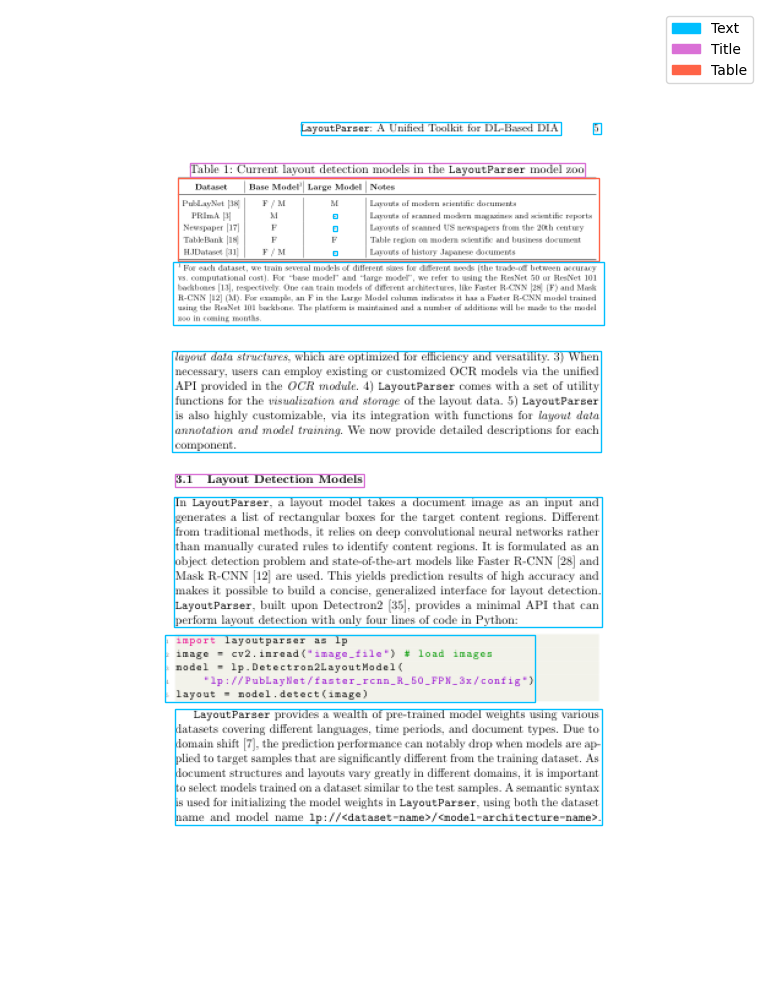

LayoutParser: A Uniﬁed Toolkit for DL-Based DIA

5

Table 1: Current layout detection models in the LayoutParser model zoo

Dataset Base Model1 Large Model Notes PubLayNet [38] F / M M Layouts of modern scientiﬁc documents PRImA [3] M - Layouts of scanned modern magazines and scientiﬁc reports Newspaper [17] F - Layouts of scanned US newspapers from the 20th century TableBank [18] F F Table region on modern scientiﬁc and business document HJDataset [31] F / M - Layouts of history Japanese documents







1 For each dataset, we train several models of diﬀerent sizes for diﬀerent needs (the trade-oﬀ between accuracy vs. computational cost). For “base model” and “large model”, we refer to using the ResNet 50 or ResNet 101 backbones [13], respectively. One can train models of diﬀerent architectures, like Faster R-CNN [28] (F) and Mask R-CNN [12] (M). For example, an F in the Large Model column indicates it has a Faster R-CNN model trained using the ResNet 101 backbone. The platform is mai

In [21]:
render_page(docs, 5)

Note that although the table text is collapsed into a single string in the document's content, the metadata contains a representation of its rows and columns:

In [22]:
from IPython.display import HTML, display

segments = [
    doc.metadata
    for doc in docs
    if doc.metadata.get("page_number") == 5 and doc.metadata.get("category") == "Table"
]

display(HTML(segments[0]["text_as_html"]))

Dataset,‘ Base Mode11|,Large Model,| Notes
PubLayNet [38],F / M,M,Layouts of modern scientific documents
PRImA [3],M,-,Layouts of scanned modern magazines and scientific reports
Newspaper,F,-,Layouts of scanned US newspapers from the 20th century
TableBank,F,F,Table region on modern scientific and business document
HJDataset n,F / M,-,Layouts of history Japanese documents


<table><thead><tr><th colspan="3">able 1. LUllclll 1ayoul actCCLloll 1110AdCs 111 L1C LayoOulralsel 1110U4cl 200</th></tr><tr><th>Dataset</th><th>| Base Model\'|</th><th>Notes</th></tr></thead><tbody><tr><td>PubLayNet [38]</td><td>F/M</td><td>Layouts of modern scientific documents</td></tr><tr><td>PRImA</td><td>M</td><td>Layouts of scanned modern magazines and scientific reports</td></tr><tr><td>Newspaper</td><td>F</td><td>Layouts of scanned US newspapers from the 20th century</td></tr><tr><td>TableBank [18]</td><td>F</td><td>Table region on modern scientific and business document</td></tr><tr><td>HJDataset</td><td>F/M</td><td>Layouts of history Japanese documents</td></tr></tbody></table>

### Extracting text from specific sections

Structures may have parent-child relationships -- for example, a paragraph might belong to a section with a title. If a section is of particular interest (e.g., for indexing) we can isolate the corresponding `Document` objects.

Below, we extract all text associated with the document's "Conclusion" section:

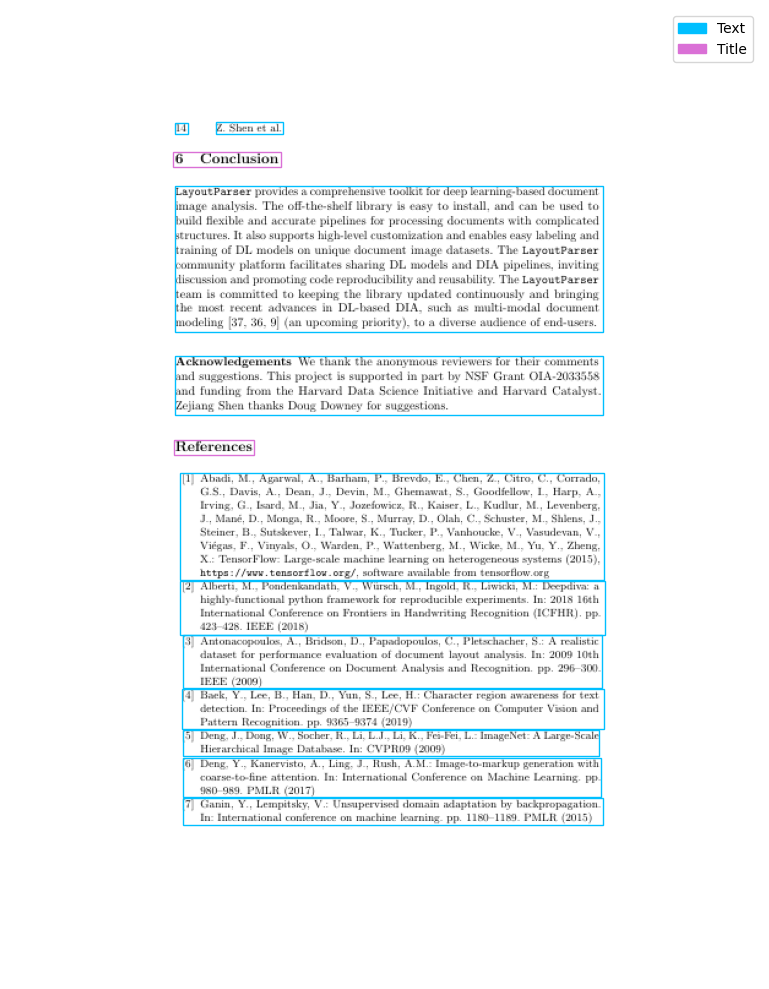

In [23]:
render_page(docs, 14, print_text=False)

In [24]:
conclusion_docs = []
parent_id = -1
for doc in docs:
    if doc.metadata["category"] == "Title" and "Conclusion" in doc.page_content:
        parent_id = doc.metadata["element_id"]
    if doc.metadata.get("parent_id") == parent_id:
        conclusion_docs.append(doc)

for doc in conclusion_docs:
    print(doc.page_content)

LayoutParser provides a comprehensive toolkit for deep learning-based document image analysis. The oﬀ-the-shelf library is easy to install, and can be used to build ﬂexible and accurate pipelines for processing documents with complicated structures. It also supports high-level customization and enables easy labeling and training of DL models on unique document image datasets. The LayoutParser community platform facilitates sharing DL models and DIA pipelines, inviting discussion and promoting code reproducibility and reusability. The LayoutParser team is committed to keeping the library updated continuously and bringing the most recent advances in DL-based DIA, such as multi-modal document modeling [37, 36, 9] (an upcoming priority), to a diverse audience of end-users.
Acknowledgements We thank the anonymous reviewers for their comments and suggestions. This project is supported in part by NSF Grant OIA-2033558 and funding from the Harvard Data Science Initiative and Harvard Catalyst. 

### Extracting text from images

OCR is run on images, enabling the extraction of text therein:

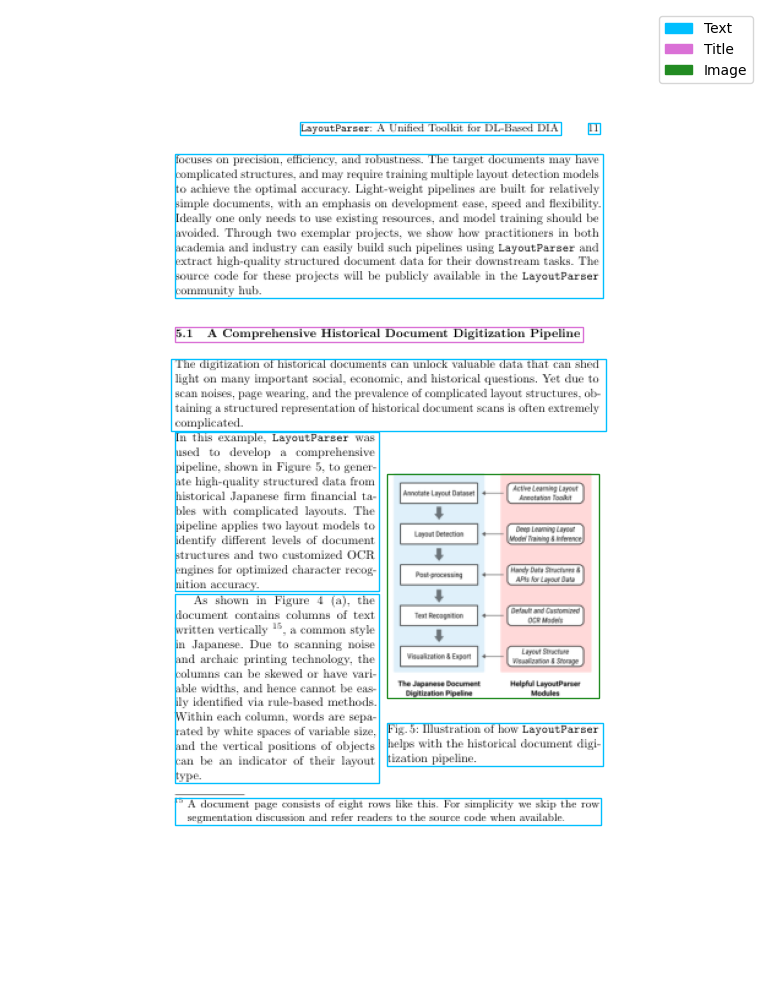

LayoutParser: A Uniﬁed Toolkit for DL-Based DIA

focuses on precision, eﬃciency, and robustness. The target documents may have complicated structures, and may require training multiple layout detection models to achieve the optimal accuracy. Light-weight pipelines are built for relatively simple documents, with an emphasis on development ease, speed and ﬂexibility. Ideally one only needs to use existing resources, and model training should be avoided. Through two exemplar projects, we show how practitioners in both academia and industry can easily build such pipelines using LayoutParser and extract high-quality structured document data for their downstream tasks. The source code for these projects will be publicly available in the LayoutParser community hub.

11

5.1 A Comprehensive Historical Document Digitization Pipeline

The digitization of historical documents can unlock valuable data that can shed light on many important social, economic, and historical questions. Yet due to scan

In [25]:
render_page(docs, 11)

Note that the text from the figure on the right is extracted and incorporated into the content of the `Document`.

### Local parsing

Parsing locally requires the installation of additional dependencies.

**Poppler** (PDF analysis)
- Linux: `apt-get install poppler-utils`
- Mac: `brew install poppler`
- Windows: https://github.com/oschwartz10612/poppler-windows

**Tesseract** (OCR)
- Linux: `apt-get install tesseract-ocr`
- Mac: `brew install tesseract`
- Windows: https://github.com/UB-Mannheim/tesseract/wiki#tesseract-installer-for-windows

We will also need to install the `unstructured` PDF extras:

In [26]:
%pip install -qU "unstructured[pdf]"

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-anthropic 0.3.0 requires anthropic<1,>=0.39.0, but you have anthropic 0.37.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


We can then use the [UnstructuredLoader](https://python.langchain.com/api_reference/unstructured/document_loaders/langchain_unstructured.document_loaders.UnstructuredLoader.html) much the same way, forgoing the API key and `partition_via_api` setting:

In [11]:
loader_local = UnstructuredLoader(
    file_path=file_path,
    strategy="hi_res",
)
docs_local = []
for doc in loader_local.lazy_load():
    docs_local.append(doc)

INFO: Reading PDF for file: /Users/chestercurme/repos/langchain/libs/community/tests/integration_tests/examples/layout-parser-paper.pdf ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Detecting page elements ...
INFO: Processing entire page OCR with tesseract...
INFO: Processing entire page OCR with tesseract...
INFO: Processing entire page OCR with tesseract...
INFO: Processing entire page OCR with tesseract...
INFO: Processing entire page OCR with tesseract...
INFO: Processing entire page OCR with tesseract...
INFO: padd

The list of documents can then be processed similarly to those obtained from the API.

## Use of multimodal models

Many modern LLMs support inference over multimodal inputs (e.g., images). In some applications-- such as question-answering over PDFs with complex layouts, diagrams, or scans-- it may be advantageous to skip the PDF parsing, instead casting a PDF page to an image and passing it to a model directly. This allows a model to reason over the two dimensional content on the page, instead of a "one-dimensional" string representation.

In principle we can use any LangChain [chat model](/docs/concepts/chat_models) that supports multimodal inputs. A list of these models is documented [here](/docs/integrations/chat/). Below we use OpenAI's `gpt-4o-mini`.

First we define a short utility function to convert a PDF page to a base64-encoded image:

In [ ]:
%pip install -qU PyMuPDF pillow langchain-openai

In [22]:
import base64
import io

import fitz
from PIL import Image


def pdf_page_to_base64(pdf_path: str, page_number: int):
    pdf_document = fitz.open(pdf_path)
    page = pdf_document.load_page(page_number - 1)  # input is one-indexed
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    return base64.b64encode(buffer.getvalue()).decode("utf-8")

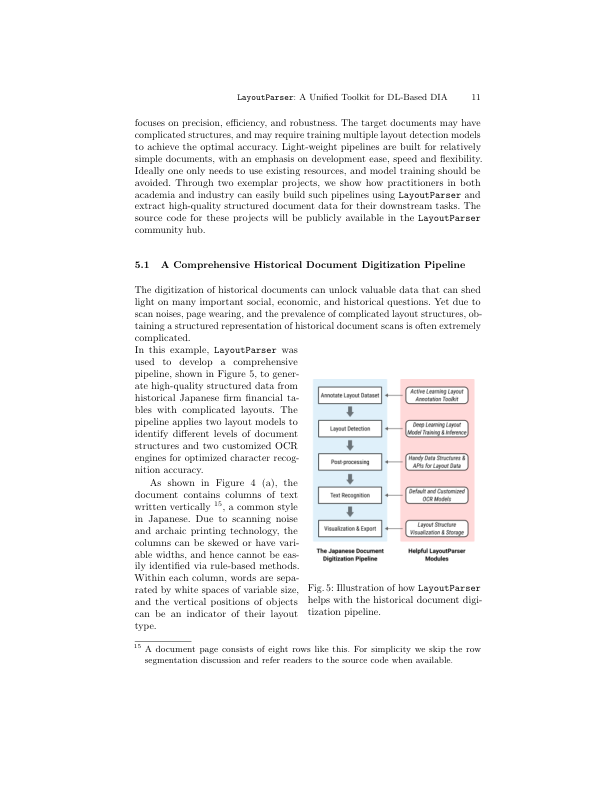

In [23]:
from IPython.display import Image as IPImage
from IPython.display import display

base64_image = pdf_page_to_base64(file_path, 11)
display(IPImage(data=base64.b64decode(base64_image)))

We can then query the model in the [usual way](/docs/how_to/multimodal_inputs/). Below we ask it a question on related to the diagram on the page.

In [24]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [25]:
from langchain_core.messages import HumanMessage

query = "What is the name of the first step in the pipeline?"

message = HumanMessage(
    content=[
        {"type": "text", "text": query},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
        },
    ],
)
response = llm.invoke([message])
print(response.content)

INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The first step in the pipeline is "Annotate Layout Dataset."


## Other PDF loaders

For a list of available LangChain PDF loaders, please see [this table](/docs/integrations/document_loaders/#pdfs).